# CS Capstone Project — LSTM modeling of Time Series Logs using both IBS SOH and Calculated SOH1 (consider all featues)

**Author:** Jason Waterman  
**Course:** UC Berkeley AI/ML Professional Certificate  
**Created:** 2025-10-28  
**Last Updated:** 2025-10-29  
**Version:** 0.1.0  

---

## 📖 Description
We now look at an expanded feature set to include all signals avaialbe on the network bus. This notebook reads in a single data log, splits up into 5 timeseries folds, splits fold into training/test/val data sets, runs a compact/robust LSTM model on both targets - IBS SOH & calculed SOH1, and compares the predicted output vs actual output. 
The unique features of this dataset is the slight fluctuation in IBS SOH during its only full charge/discharge cycle from 66->64->68% all occuring during <30min time window.

### 🔑 Objectives
- Perform additional data preprocessing on all features preparing it for ingestion on LSTM model
- Create a compact & robust LSTM model architecture appropriate for data set being analyzed
- Perform LSTM model train/val/test on both targets - IBS SOH and calculated SOH1. A new training is performed for each time series fold. 
- Plot initial results on test data across each fold. 
- Perform a complete LSTM model refit using all the data in the time series. This gives a better idea of the capability of the model for actual deployment. 

### 💡 Insights and next steps
- Expanding our signal set to include all networ signals gives a much richer feature set to explore the enhanced capabilities of LSTM modeling. Our feature set expanded to 666 features which increased in size slightly to 768 once we performed the one-hot encoding of the non-numeric features. In the future we can also consider Ordinal Coding instead to keep the feature set tighter. 
- Looking at the initial results for the LSTM CV overlay are somewhat visually misleading. What we see is only the results on the test data. It appears delayed due to the 60s time window for model to effectively "warm up" and start reporting predicted results. The results may be extrapolated over the entire time series fold to better get a sense of the actual results. 
- Therefore, to get a better idea of the capability of the LSTM model used for actual deployment we perform and additional step — a final model refit on the entire data series. This gives us an indication of what the model is capable of when it has the entire time series data history to pull from. As can be seen, our LSTM model performs very well relative to the actual data for both IBS SOH and calculated SOH, not due to data leakage, but due to having access to complete time history. Hence it is able to learn the temporal dynamics of the data. 

## 1. Setup, imports, and config

In [12]:
# Import all the necessary libraries to be used by this script

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
import warnings

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Load project utilities contained in /src
from cs_soh_utils import calculate_soh1, detect_cycles_from_voltage, count_cycles_voltage, merge_short_gaps, parse_log_date, compute_log_soh, attach_soh1_series, ensure_time_index_1s

PREPROCESSED_CSV_DIR = Path("can_data/lstm_preprocessed") 

warnings.filterwarnings("ignore")

## 2. Load in cleand & raw data file. Perform the necessary preprocesing so that data may be ingested by LSTM.
- Load in data from /lstm_preprocessed/*_cleaned_raw.csv
- Calculate SOH1 (pull from utility library)
- Save orginal non-scaled IBS SOH and calculated SOH
- Remove duplicates, backfill NaN
- Drop not interesting data such as checksums and alivecounters
- Standard scaling on all numeric data
- One hot encoding for all non-numeric data

In [13]:
# Load in clean_raw data for Log Id: 06-29_08-10-35
# cleaned & raw means: completely cleaned data set before one-hot encoding and standard scaling is applied. Orginal IBS_StateOfHealth maintained. 

path = PREPROCESSED_CSV_DIR / "12V Management  Discharge and Charge Cycle 2025-06-29_08-10-35_cleaned_raw.csv"
df = pd.read_csv(path)
df_raw = df.copy()  # create a copy for SOH1 calculation

# Set datetime as index in correct format

df["time_utc_iso"] = pd.to_datetime(df["time_utc_iso"], unit="ns", utc=True)
df = df.set_index("time_utc_iso").sort_index()

# Quick check on timeseries, shape of data log, and # of features
print(df.index[:5])
print(df.index.dtype)   # should show datetime64[ns, UTC]
print(df.shape)
print(df.columns)

DatetimeIndex(['2025-06-29 12:10:35+00:00', '2025-06-29 12:10:36+00:00',
               '2025-06-29 12:10:37+00:00', '2025-06-29 12:10:38+00:00',
               '2025-06-29 12:10:39+00:00'],
              dtype='datetime64[ns, UTC]', name='time_utc_iso', freq=None)
datetime64[ns, UTC]
(4734, 666)
Index(['VCU_214_234_CheckSum', 'VCU_214_234_AliveCounter',
       'VCU_214_234_CheckSum.1', 'VCU_214_234_AliveCounter.1',
       'CIM_189_CheckSum', 'CIM_189_AliveCounter', 'VCU_100_110_CheckSum',
       'VCU_100_110_AliveCounter', 'VCU_101_111_CheckSum',
       'VCU_101_111_AliveCounter',
       ...
       'VCU_LVbattCtrlSigSTGFlt', 'VCU_93_AliveCounter',
       'VCU_HVBActivateDeactivateRq', 'VCU_Set_BMS_Mod',
       'IBS_CurrentAutorange', 'VSP_HornWngSts', 'VSP_WngMod',
       'VSP_UsrData1_Bit6_DIAGN_AWAKE', 'WTC_B_HVPwrSplySts',
       'WTC_H_HVPwrSplySts'],
      dtype='object', length=666)


In [14]:
# perform a quick check of the calculated SOH1
df_soh1 = calculate_soh1(
    df, 
    return_components=True, 
    return_series=True, 
    resample_s=2,          # <-- match legacy
    return_vendor=False
)
soh1_series = df_soh1['SOH1']
print(soh1_series)

2025-06-29 12:10:35    0.473291
2025-06-29 12:10:36    0.473291
2025-06-29 12:10:37    0.473291
2025-06-29 12:10:38    0.473291
2025-06-29 12:10:39    0.473291
                         ...   
2025-06-29 13:29:24    0.301955
2025-06-29 13:29:25    0.301955
2025-06-29 13:29:26    0.301955
2025-06-29 13:29:27    0.301955
2025-06-29 13:29:28    0.301955
Freq: s, Name: SOH1, Length: 4734, dtype: float64


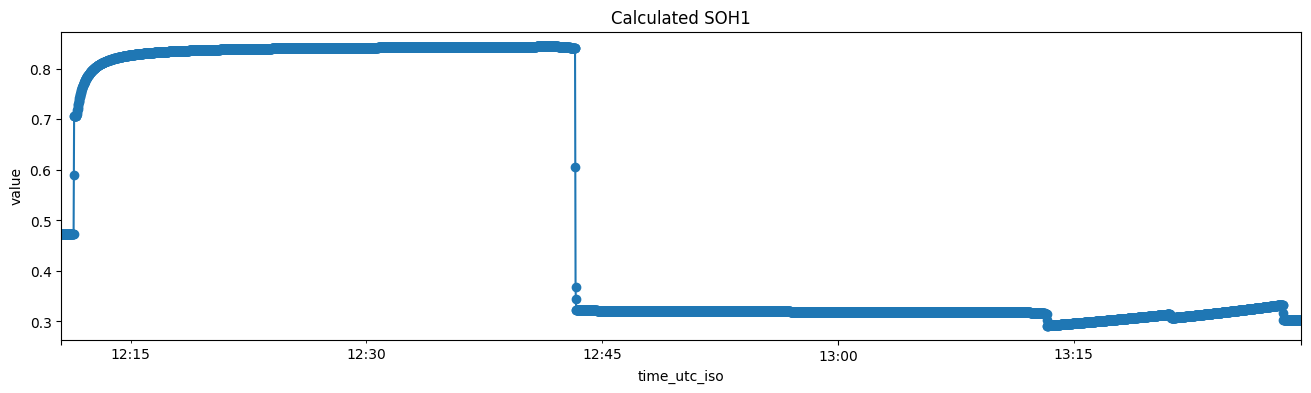

In [15]:
# Let's also plot it as a sanity check

soh1_series.plot(figsize=(16,4), marker="o")
plt.xlabel("time_utc_iso")
plt.ylabel("value")
plt.title("Calculated SOH1")
plt.show()


In [16]:
# Preprocessing of data for ingestion into the LSTM
# Perform some quick checks of the feature set size at each stage to get a feeling of the effects of each step

print("Orginal data shape:", df.shape)

# Make sure that time series data is down sampled at 1S before continuing

# 1) Numeric columns → median per second
df_num = df.resample("1S").median(numeric_only=True)

# 2) The rest (non-numeric) → take the last value seen each second, then forward-fill gaps
non_num_cols = df.columns.difference(df_num.columns)
df_non = df[non_num_cols].resample("1S").last().ffill()

# 3) Recombine and keep as your working df
df = pd.concat([df_num, df_non], axis=1).sort_index()

print("Downsampled data shape:", df.shape)

## Drop un-useful data

# drop constant cols
df = df.loc[:, df.nunique() > 1]

# drop mostly empty cols
missing_thresh = 0.5
df = df.loc[:, df.isnull().mean() < missing_thresh]

# drop checksums and alivecounters
df = df.drop(columns=df.filter(like="CheckSum").columns)
df = df.drop(columns=df.filter(like="AliveCounter").columns)
df = df.drop(columns=df.filter(like="BMS_CellVolt").columns)

print("Good data shape:", df.shape)

## First process numeric features ##

numeric_df = df.select_dtypes(include=["number"])
soh_series = numeric_df['IBS_StateOfHealth']

# Scale numeric data
scaler = StandardScaler()
scaled = scaler.fit_transform(numeric_df)
df_scaled = pd.DataFrame(scaled, index=df.index, columns=numeric_df.columns)

# Add back both SOH1 and IBS SOH as unscaled versions
df_scaled['SOH1'] = soh1_series.values     # Add unscaled calculated SOH1
df_scaled['IBS_StateOfHealth'] = soh_series.values  # Add back unscaled IBS SOH

print("Numeric data shape:", df_scaled.shape)

## Second process non-numeric featues ##
non_numeric_cols = df.select_dtypes(exclude=["number"]).columns
print("Non-numeric columns:", non_numeric_cols)

# One-hot encode what we are able to #

# Fill missing cells with a string so it encodes cleanly
cat_df = df[non_numeric_cols].fillna("missing").astype("category")
cat_encoded = pd.get_dummies(cat_df, drop_first=False)

# Remove columns that cannot be encoded
max_unique = 50  # adjust threshold
to_drop = [c for c in cat_df.columns if cat_df[c].nunique() > max_unique]

# Finally perform one-hot encoding
cat_encoded = pd.get_dummies(cat_df.drop(columns=to_drop), drop_first=False)

print("One-hot encoded data shape", cat_encoded.shape)

## Finally merge non-numeric back with the already scaled numeric data

df_final = pd.concat([df_scaled, cat_encoded], axis=1)

print("Final LSTM data set shape:", df_final.shape)
print(df_final.index[:5])
print(df_final)

Orginal data shape: (4734, 666)


Downsampled data shape: (4734, 666)
Good data shape: (4734, 412)
Numeric data shape: (4734, 221)
Non-numeric columns: Index(['ADAS_DOW_Sts', 'ADAS_ESAState', 'ADAS_LCA_Sts', 'ADAS_LKASts',
       'BCM_AntithftSts', 'BCM_BucSwtSt2ndRowLeft', 'BCM_BucSwtSt2ndRowMid',
       'BCM_BucSwtSt2ndRowRight', 'BCM_BucSwtSt3rdRowLeft',
       'BCM_BucSwtSt3rdRowRight',
       ...
       'VCU_VehChrgDchgMod', 'VCU_VehChrgDchgMod.1', 'VCU_VehMod', 'VCU_VehSt',
       'VCU_VehSt.1', 'VSP_HornWngSts', 'VSP_UsrData1_Bit6_DIAGN_AWAKE',
       'VSP_WngMod', 'WTC_B_HVPwrSplySts', 'WTC_H_HVPwrSplySts'],
      dtype='object', length=192)
One-hot encoded data shape (4734, 547)
Final LSTM data set shape: (4734, 768)
DatetimeIndex(['2025-06-29 12:10:35+00:00', '2025-06-29 12:10:36+00:00',
               '2025-06-29 12:10:37+00:00', '2025-06-29 12:10:38+00:00',
               '2025-06-29 12:10:39+00:00'],
              dtype='datetime64[ns, UTC]', name='time_utc_iso', freq='s')
                           MCU_F_

In [17]:
# Save cleaned data file for future usage  
path = PREPROCESSED_CSV_DIR / "12V Management  Discharge and Charge Cycle 2025-06-29_08-10-35_cleaned_scaled.csv"
df_final.to_csv(path)

## 2. Build necessary helper functions

In [18]:
## Include all necessary helper functions ##

# Window the data into sequences ##

def make_sliding_windows(X, y, seq_len=120, stride=1, horizon=1):
    """
    X: (T, F), y: (T, 1)
    Returns X_seq: (N, seq_len, F), y_seq: (N, 1) where target is at t+ horizon-1
    """
    T = len(X)
    X_seq, y_seq = [], []
    end = T - seq_len - horizon + 1
    for start in range(0, max(end, 0), stride):
        stop = start + seq_len
        X_seq.append(X[start:stop])
        y_seq.append(y[stop + horizon - 1])
    if len(X_seq) == 0:
        return np.empty((0, seq_len, X.shape[1])), np.empty((0, 1))
    return np.stack(X_seq), np.stack(y_seq)


## Plot CV overlay of stiched data folds ##

def plot_lstm_cv_overlay(df, target_col, y_pred_full, test_spans, title=None):
    fig, ax = plt.subplots(figsize=(14, 3.5))

    # 1) full actual series
    ax.plot(df.index, df[target_col].to_numpy(), label="Actual", linewidth=2)

    # 2) stitched predictions (dashed line; NaNs break the line between folds)
    ax.plot(y_pred_full.index, y_pred_full.to_numpy(),
            linestyle="--", linewidth=2, label="Predicted (CV test)")

    # 3) shade test folds + optional vertical boundaries + labels
    for i, (ts, te) in enumerate(test_spans, start=1):
        ax.axvspan(ts, te, alpha=0.12, color="tab:blue",
                   label="Test Fold" if i == 1 else None)
        # boundary lines (dashed) at each fold start except the very first timestamp
        ax.axvline(ts, linestyle=":", alpha=0.5, color="k")
        # label at fold center
        mid = ts + (te - ts) / 2
        ax.text(mid, ax.get_ylim()[0] + 0.92*(ax.get_ylim()[1]-ax.get_ylim()[0]),
                f"Fold {i}", ha="center", va="bottom", fontsize=9, alpha=0.9)

    # make last fold end boundary visible
    if test_spans:
        ax.axvline(test_spans[-1][1], linestyle=":", alpha=0.5, color="k")

    ax.set_title(title or f"LSTM TimeSeriesSplit ({len(test_spans)}-fold) — {target_col}")
    ax.set_ylabel(target_col)
    ax.legend(loc="upper left")
    ax.grid(True, alpha=0.2)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


## 3. Build compact / robust LSTM

In [19]:
# Build compact and robust LSTM

def build_lstm(n_features, seq_len, units=128, dropout=0.20, lr=1e-3):
    inputs = layers.Input(shape=(seq_len, n_features))
    x = layers.Masking(mask_value=0.0)(inputs)        
    x = layers.LSTM(units, return_sequences=True)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.LSTM(units // 2)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units // 2, activation="relu")(x)
    outputs = layers.Dense(1)(x)                      # linear for regression
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tf.keras.losses.Huber(delta=1.0),        # a bit more robust than MSE to spikes
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

# sanity check callbacks 

def default_callbacks():
    return [
        callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
    ]


## 4. Main Loop - Train LSTM CV across data log folds for each TARGET (SOH and SOH1)
- Split data using time series within multiple folds (5)
- Execute LSTM on each fold for each target (SOH and SOH1)
- Plot actual vs predicted each target (SOH and SOH1)
- Calculate error metrics for each fold and print error metric table

[IBS_StateOfHealth] Fold 1: RMSE=0.0393, R2=0.000
[IBS_StateOfHealth] Fold 2: RMSE=0.0278, R2=0.000
[IBS_StateOfHealth] Fold 3: RMSE=0.0984, R2=0.000
[IBS_StateOfHealth] Fold 4: RMSE=0.0150, R2=0.000
[IBS_StateOfHealth] Fold 5: RMSE=5.2304, R2=0.000


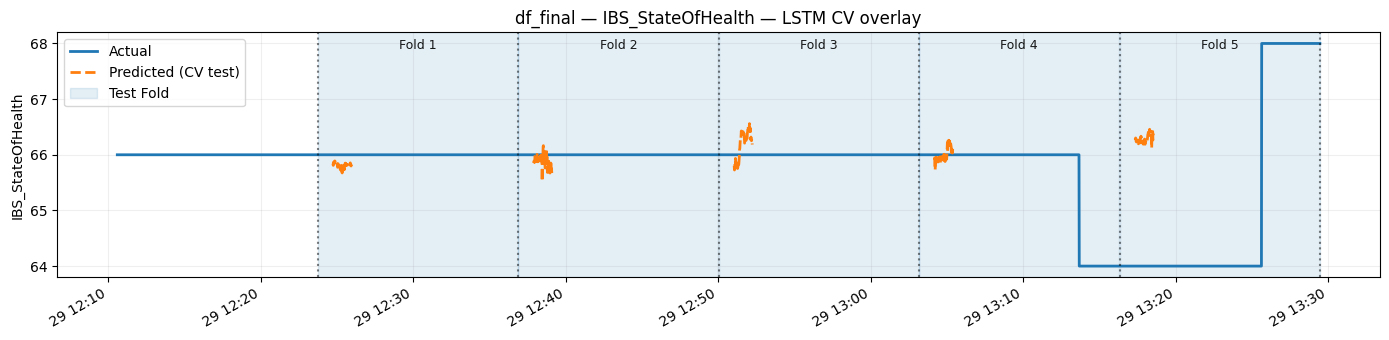

,target,fold,rmse,r2,seq_len,stride,horizon,units,dropout,epochs,batch,lr
0,IBS_StateOfHealth,1,0.0393,0.000,60,10,1,128,0.200000,30,64,0.001000
1,IBS_StateOfHealth,2,0.0278,0.000,60,10,1,128,0.200000,30,64,0.001000
2,IBS_StateOfHealth,3,0.0984,0.000,60,10,1,128,0.200000,30,64,0.001000
3,IBS_StateOfHealth,4,0.0150,0.000,60,10,1,128,0.200000,30,64,0.001000
4,IBS_StateOfHealth,5,5.2304,0.000,60,10,1,128,0.200000,30,64,0.001000


[SOH1] Fold 1: RMSE=0.0022, R2=-135860.529
[SOH1] Fold 2: RMSE=0.0026, R2=-2115704.929
[SOH1] Fold 3: RMSE=0.1093, R2=0.000
[SOH1] Fold 4: RMSE=0.0077, R2=-2511752464574674294311848247296.000
[SOH1] Fold 5: RMSE=0.0253, R2=-23714.926


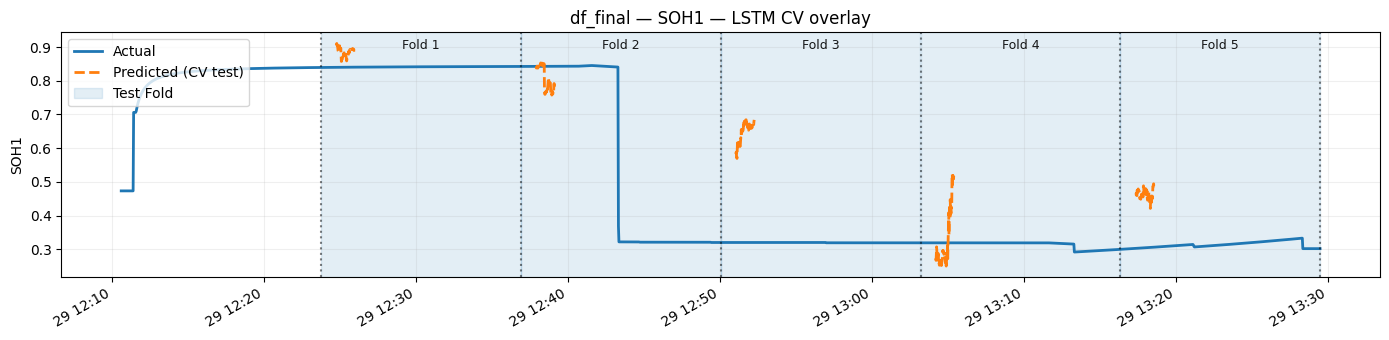

,target,fold,rmse,r2,seq_len,stride,horizon,units,dropout,epochs,batch,lr
0,SOH1,1,0.0022,-135860.529,60,10,1,128,0.200000,30,64,0.001000
1,SOH1,2,0.0026,-2115704.929,60,10,1,128,0.200000,30,64,0.001000
2,SOH1,3,0.1093,0.000,60,10,1,128,0.200000,30,64,0.001000
3,SOH1,4,0.0077,-2511752464574674294311848247296.000,60,10,1,128,0.200000,30,64,0.001000
4,SOH1,5,0.0253,-23714.926,60,10,1,128,0.200000,30,64,0.001000


In [20]:
# === LSTM CV inline (outer: target_col, inner: folds) using df_final X/y and your build_lstm ===

import tensorflow as tf
from tensorflow.keras import callbacks, layers, models
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# --- hyperparams (note lr to match build_lstm signature) ---
SEQ_LEN, STRIDE, HORIZON = 60, 10, 1
N_SPLITS = 5
UNITS    = 128
DROPOUT  = 0.20
EPOCHS   = 30
BATCH    = 64
LR       = 1e-3  # << used by build_lstm(..., lr=LR)

# Use your default callbacks helper
cb = default_callbacks()

targets = ["IBS_StateOfHealth", "SOH1"]

all_fold_tables_lstm = []
preds_by_target = {}

for target_col in targets:
    # --- define y and X exactly as requested ---
    y = df_final[target_col].copy()
    X = df_final.drop(columns=[target_col, "SOH1", "IBS_StateOfHealth"]).copy()

    # --- align & drop NaNs together ---
    xy = pd.concat([X, y], axis=1).dropna()
    X = xy.drop(columns=[target_col])
    y = xy[target_col]
    used_feats = list(X.columns)

    # --- CV splits (time-aware) ---
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    splits = list(tscv.split(X))

    # --- per-target stores ---
    y_pred_full = pd.Series(index=y.index, dtype=float)
    fold_metrics = []
    test_spans = []

    for fold, (train_idx, test_idx) in enumerate(splits, start=1):
        # 90/10 val split inside train (chronological)
        n_val = max(1, int(0.10 * len(train_idx)))
        tr_core_idx = train_idx[:-n_val]
        val_idx     = train_idx[-n_val:]

        # numpy arrays for TF
        X_train = X.iloc[tr_core_idx].to_numpy()
        y_train = y.iloc[tr_core_idx].to_numpy().reshape(-1, 1)
        X_val   = X.iloc[val_idx].to_numpy()
        y_val   = y.iloc[val_idx].to_numpy().reshape(-1, 1)
        X_test  = X.iloc[test_idx].to_numpy()
        y_test  = y.iloc[test_idx].to_numpy().reshape(-1, 1)

        # scale on TRAIN only
        x_scaler = StandardScaler().fit(X_train)
        y_scaler = StandardScaler().fit(y_train)

        X_train_s = x_scaler.transform(X_train).astype("float32")
        X_val_s   = x_scaler.transform(X_val).astype("float32")
        X_test_s  = x_scaler.transform(X_test).astype("float32")
        y_train_s = y_scaler.transform(y_train).astype("float32")
        y_val_s   = y_scaler.transform(y_val).astype("float32")
        y_test_s  = y_scaler.transform(y_test).astype("float32")

        # windowed sequences (label at t + HORIZON - 1)
        Xtr_seq, ytr_seq = make_sliding_windows(X_train_s, y_train_s, seq_len=SEQ_LEN, stride=STRIDE, horizon=HORIZON)
        Xv_seq,  yv_seq  = make_sliding_windows(X_val_s,   y_val_s,   seq_len=SEQ_LEN, stride=STRIDE, horizon=HORIZON)
        Xte_seq, yte_seq = make_sliding_windows(X_test_s,  y_test_s,  seq_len=SEQ_LEN, stride=STRIDE, horizon=HORIZON)

        if len(Xtr_seq)==0 or len(Xv_seq)==0 or len(Xte_seq)==0:
            print(f"[{target_col}] Fold {fold}: not enough rows for windows (SEQ_LEN={SEQ_LEN}). Skipping.")
            continue

        # build + train model (uses your build_lstm signature)
        n_features = X_train_s.shape[1]
        model = build_lstm(n_features=n_features, seq_len=SEQ_LEN, units=UNITS, dropout=DROPOUT, lr=LR)

        model.fit(
            Xtr_seq, ytr_seq,
            validation_data=(Xv_seq, yv_seq),
            epochs=EPOCHS, batch_size=BATCH, verbose=0, callbacks=cb
        )

        # predict on test windows and invert scaling
        y_pred_s = model.predict(Xte_seq, verbose=0).ravel()
        y_pred   = y_scaler.inverse_transform(y_pred_s.reshape(-1,1)).ravel()

        # align predictions to the true test timestamps
        offset = SEQ_LEN + HORIZON - 1
        test_index = y.index[test_idx]
        ts_aligned = test_index[offset:offset + len(y_pred)]
        y_pred_full.loc[ts_aligned] = y_pred

        # metrics on aligned labels
        y_true_match = y.loc[ts_aligned].to_numpy()
        rmse = mean_squared_error(y_true_match, y_pred)
        r2   = r2_score(y_true_match, y_pred)

        # track whole test fold span for overlay shading
        test_spans.append((test_index.min(), test_index.max()))
        fold_metrics.append({
            "target": target_col,
            "fold": fold,
            "rmse": rmse,
            "r2": r2,
            "seq_len": SEQ_LEN, "stride": STRIDE, "horizon": HORIZON,
            "units": UNITS, "dropout": DROPOUT, "epochs": EPOCHS, "batch": BATCH, "lr": LR
        })
        print(f"[{target_col}] Fold {fold}: RMSE={rmse:.4f}, R2={r2:.3f}")

    # --- OPTIONAL (recommended for clean stitching on full df_final.index) ---
    # reindex predictions to df_final.index so the dashed line spans the same canvas as actuals
    y_pred_plot = y_pred_full.reindex(df_final.index)

    # ==== Use your LSTM-specific plotting function here ====
    plot_lstm_cv_overlay(
        df=df_final,
        target_col=target_col,
        y_pred_full=y_pred_plot,   # pass the reindexed series
        test_spans=test_spans,
        title=f"{df_final.attrs.get('source','df_final')} — {target_col} — LSTM CV overlay"
    )

    # per-target table
    fold_df = pd.DataFrame(fold_metrics)[
        ["target", "fold", "rmse", "r2", "seq_len", "stride", "horizon", "units", "dropout", "epochs", "batch", "lr"]
    ]
    try:
        display(fold_df.style.format({"rmse":"{:.4f}", "r2":"{:.3f}"}))
    except Exception:
        print(fold_df)
        all_fold_tables_lstm.append(fold_df)
        preds_by_target[target_col] = y_pred_full


## Final LSTM model refit on full series — continuous prediction 
After you’re satisfied with walk-forward metrics, refit one model on (train+val=all data) and infer with stride=1 over the entire series. This gives us an understanding of the LSTM model when used for actual deployment. 

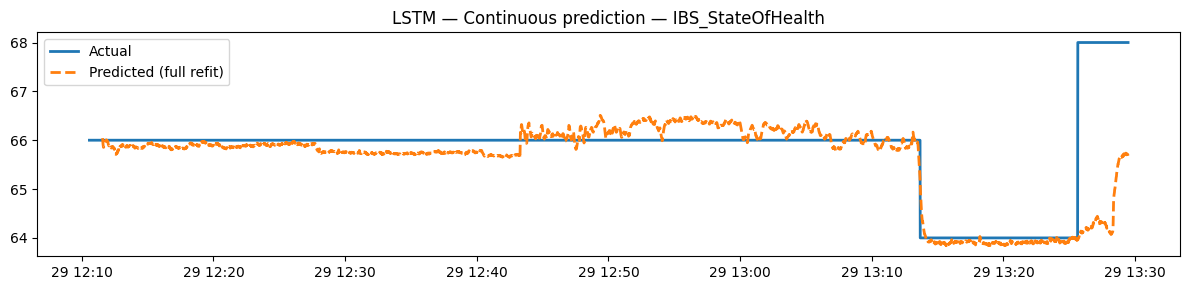

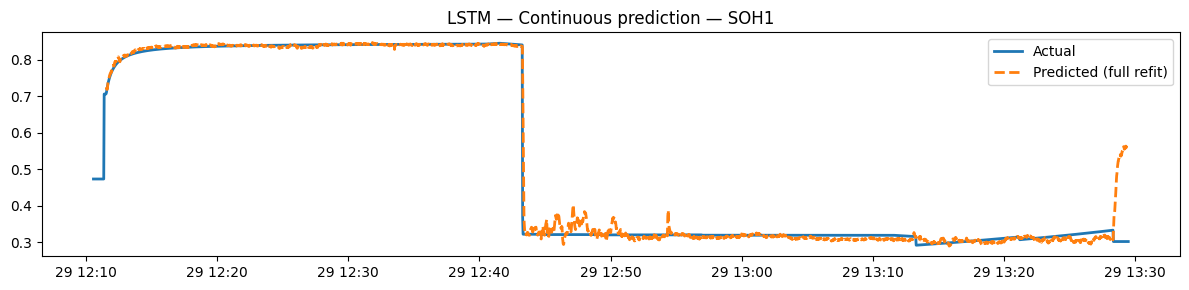

,target,n_points,coverage_%,mae,rmse,r2,mape_%,seq_len,horizon,stride_train,units,dropout,epochs,batch,lr
0,IBS_StateOfHealth,4674,98.73,0.3415,0.7956,0.175,0.51,60,1,10,128,0.200000,30,64,0.001000
1,SOH1,4674,98.73,0.0103,0.0309,0.985,3.05,60,1,10,128,0.200000,30,64,0.001000


In [22]:
# ===== Final refit (per target) with dense inference (stride=1) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Hyperparams (reuse from CV or adjust)
SEQ_LEN        = 60
HORIZON        = 1
STRIDE_TRAIN   = 10   # window stride during training (keeps training set smaller/faster)
EPOCHS         = 30
BATCH          = 64 
UNITS          = 128
DROPOUT        = 0.20
LR             = 1e-3

targets = ["IBS_StateOfHealth", "SOH1"]

# Helper for dense inference across a full (scaled) series
def dense_infer_series(model, X_s, y_s, seq_len=SEQ_LEN, horizon=HORIZON):
    """
    Returns:
      yhat: (num_windows,) array of predictions
      pos:  positions in the original index where each yhat applies
    """
    Xseq, _ = make_sliding_windows(X_s, y_s, seq_len=seq_len, stride=1, horizon=horizon)
    if len(Xseq) == 0:
        return np.array([]), np.array([], dtype=int)
    yhat = model.predict(Xseq, verbose=0).ravel()
    start = seq_len + horizon - 1
    pos = np.arange(start, start + len(yhat), dtype=int)
    return yhat, pos

dense_preds_by_target = {}
final_refit_metrics_rows = []  

for TARGET_COL in targets:
    # --- Define X_all / y_all exactly as per your rule ---
    y_all = df_final[TARGET_COL].copy()
    X_all = df_final.drop(columns=[TARGET_COL, "SOH1", "IBS_StateOfHealth"]).copy()

    # Align and drop NaNs together
    xy_all = pd.concat([X_all, y_all], axis=1).dropna()
    X_all = xy_all.drop(columns=[TARGET_COL])
    y_all = xy_all[TARGET_COL]

    # Scale on full series (deployment-style visualization)
    x_scaler_full = StandardScaler().fit(X_all)
    y_scaler_full = StandardScaler().fit(y_all.to_numpy().reshape(-1,1))

    X_all_s = x_scaler_full.transform(X_all).astype("float32")
    y_all_s = y_scaler_full.transform(y_all.to_numpy().reshape(-1,1)).astype("float32")

    # Keep small tail as validation (chronological)
    n_val = max(1, int(0.1 * len(X_all_s)))
    Xtr_all, Xv_all = X_all_s[:-n_val], X_all_s[-n_val:]
    ytr_all, yv_all = y_all_s[:-n_val], y_all_s[-n_val:]

    # Windowed train/val (use a larger stride for training windows to reduce load)
    Xtr_seq, ytr_seq = make_sliding_windows(
        Xtr_all, ytr_all, seq_len=SEQ_LEN, stride=STRIDE_TRAIN, horizon=HORIZON
    )
    Xv_seq, yv_seq = make_sliding_windows(
        Xv_all, yv_all, seq_len=SEQ_LEN, stride=STRIDE_TRAIN, horizon=HORIZON
    )

    if len(Xtr_seq) == 0 or len(Xv_seq) == 0:
        print(f"[{TARGET_COL}] Not enough data for seq_len={SEQ_LEN} / horizon={HORIZON}. Skipping.")
        continue

    # Build and train the final model for this target
    n_feat = X_all_s.shape[1]
    model_full = build_lstm(n_features=n_feat, seq_len=SEQ_LEN, units=UNITS, dropout=DROPOUT, lr=LR)
    model_full.fit(
        Xtr_seq, ytr_seq,
        validation_data=(Xv_seq, yv_seq),
        epochs=EPOCHS, batch_size=BATCH, verbose=0, callbacks=default_callbacks()
    )

    # Dense inference (stride=1) across the full series (scaled)
    yhat_all, pos = dense_infer_series(model_full, X_all_s, y_all_s, seq_len=SEQ_LEN, horizon=HORIZON)
    if len(yhat_all) == 0:
        print(f"[{TARGET_COL}] Dense inference produced no windows. Skipping plot.")
        continue

    # Inverse scale predictions + stitch onto the (post-dropna) index
    yhat_all_inv = y_scaler_full.inverse_transform(yhat_all.reshape(-1,1)).ravel()

    # Map predictions to the xy_all index positions (same length as X_all/y_all)
    # pos values are relative to the *xy_all* arrays, so index with xy_all.index
    idx = xy_all.index
    y_pred_cont = pd.Series(yhat_all_inv, index=idx[pos])

    # Optional: reindex to full df_final index and forward-fill for an unbroken line
    y_pred_dense = y_pred_cont.reindex(df_final.index)
    if len(pos):
        first = pos[0]
        # set pre-label area to NaN, then ffill to draw a continuous dashed line
        y_pred_dense.iloc[:first] = np.nan
    y_pred_dense = y_pred_dense.ffill()

    # Save for later use if needed
    dense_preds_by_target[TARGET_COL] = y_pred_dense

    # ---------- METRICS (per target; matches the plotted series) ----------
    from sklearn.metrics import mean_squared_error, r2_score

    # Use only timestamps where we have model predictions (post-offset; excludes initial NaNs)
    mask = y_pred_dense.notna() & df_final[TARGET_COL].notna()
    y_true = df_final.loc[mask, TARGET_COL].astype(float).to_numpy()
    y_pred = y_pred_dense.loc[mask].astype(float).to_numpy()

    def mae(a, p):  return float(np.mean(np.abs(a - p))) if len(a) else np.nan
    def rmse(a, p): return float(np.sqrt(mean_squared_error(a, p))) if len(a) else np.nan
    def r2(a, p):   return float(r2_score(a, p)) if len(a) > 1 else np.nan
    def mape(a, p):
        denom = np.where(a == 0, np.nan, np.abs(a))
        return float(np.nanmean(np.abs(a - p) / denom) * 100.0)

    metrics_rows = globals().get("final_refit_metrics_rows", [])
    if metrics_rows is None:
        metrics_rows = []
    globals()["final_refit_metrics_rows"] = metrics_rows

    metrics_rows.append({
        "target": TARGET_COL,
        "n_points": int(mask.sum()),
        "coverage_%": round(100.0 * mask.mean(), 2),
        "mae": mae(y_true, y_pred),
        "rmse": rmse(y_true, y_pred),
        "r2": r2(y_true, y_pred),
        "mape_%": mape(y_true, y_pred),
        "seq_len": SEQ_LEN, "horizon": HORIZON, "stride_train": STRIDE_TRAIN,
        "units": UNITS, "dropout": DROPOUT, "epochs": EPOCHS, "batch": BATCH, "lr": LR
    })


    # --- Plot one figure per target ---
    plt.figure(figsize=(12, 3))
    plt.plot(df_final.index, df_final[TARGET_COL].to_numpy(), lw=2, label="Actual")
    plt.plot(df_final.index, y_pred_dense.to_numpy(), "--", lw=2, label="Predicted (full refit)")
    plt.title(f"LSTM — Continuous prediction — {TARGET_COL}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- DISPLAY METRICS TABLE ----------
if "final_refit_metrics_rows" in globals() and final_refit_metrics_rows:
    final_refit_metrics_df = pd.DataFrame(final_refit_metrics_rows)[
        ["target","n_points","coverage_%","mae","rmse","r2","mape_%",
         "seq_len","horizon","stride_train","units","dropout","epochs","batch","lr"]
    ]
    try:
        display(final_refit_metrics_df.style.format({
            "mae":"{:.4f}", "rmse":"{:.4f}", "r2":"{:.3f}", "mape_%":"{:.2f}", "coverage_%":"{:.2f}"
        }))
    except Exception:
        print(final_refit_metrics_df)
else:
    print("No metrics to show (no predictions produced).")
